In [79]:
import warnings
warnings.filterwarnings("ignore")

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
import os
from abc import abstractmethod

In [81]:
OUTPUT_PATH = 'output/'
INPUT_PATH = 'dataset/'
BASE_FILE_NAME='btcusdt'
TIME_FRAMES=['1h']

SIGNALS = [-1,0,1]
PRICE_TYPES = ['open','close','high','low']

TIMEFRAME="1h"

PRICE_STUDY="close"
PRICE_TRADING="open"
RISK_FREE_RATE=4.04

In [82]:
class PrVO:
    def __init__(self,open:float,high:float,low:float,close:float,volume:int,timeStamp:datetime) -> None:
        self.open = open
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.timeStamp = timeStamp
        self.returns = (close - open)/open
        self.candle_color = 'GREEN' if self.close > self.open else 'RED'

    def __repr__(self) -> str:
        return f"Price-Volume : open={self.open}, high={self.high},low={self.low}, close={self.close}, volume={self.volume}, timeStamp={self.timeStamp}"
    
    def __str__(self) -> str:
        return f"Price-Volume : open={self.open}, high={self.high},low={self.low}, close={self.close}, volume={self.volume}, timeStamp={self.timeStamp}"
    
class Trade:
    
    def __init__(self) -> None:
        self.timeStamp = None
        self.signal = None
        self.price_type = None
    
    def execute(self,PrVo:PrVO ,signal:int,price_type:str) -> object:
        
        assert signal in SIGNALS, f"Invalid Signal {signal}"
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"

        self.PrVo = PrVo
        self.signal = signal
        self.price_type = price_type
        return self
    
    def __str__(self) -> str:
        return f"{self.PrVo}\t{self.signal}\t {self.price_type}"
    

In [83]:
class TradingTerminal:

    def __init__(self) -> None:
        self.PrVo=dict()
        self.cash_balance=1000
        self.tradeHistory=[]
        self.transaction_penalty=0.001
        self.transaction_cost=0

        if '1d' in TIME_FRAMES:
            self.create1DTimeFrame()

        for timeframe in TIME_FRAMES:
            self.readData(BASE_FILE_NAME+'_'+timeframe+'.xlsx')

    def create1DTimeFrame(self):
        
        if os.path.isfile(INPUT_PATH+BASE_FILE_NAME+'_1d.xlsx'):
            return
        df=pd.read_excel(INPUT_PATH+BASE_FILE_NAME+'_30m.xlsx')
        df['date']=df['datetime'].dt.date
        df['time']=df['datetime'].dt.time
        df=df.drop(columns=['datetime'])
        df=df.drop(columns=['time'])
        df=df.rename(columns={'date':'datetime'})
        df=df.groupby('datetime').agg({'low':lambda x: x.min(),'high':lambda x: x.max(),'open':lambda x: x.iloc[0],'close':lambda x: x.iloc[-1],'volume':lambda x: x.sum()})
        df.to_excel(INPUT_PATH+BASE_FILE_NAME+'_1d.xlsx')

    def readData(self,filepath:str):
        df=pd.read_excel(INPUT_PATH+filepath)
        
        data=[]
        for index,row in df.iterrows():
            data.append(PrVO(row['open'],row['high'],row['low'],row['close'],row['volume'],row['datetime']))

        data_timeframe=filepath.split('/')[-1].split('.')[0].split('_')[1]
        self.PrVo[data_timeframe]=np.array(data)
        
    def takeTrade(self,PrVo:PrVO,signal:int,price_type:str):
        assert signal in SIGNALS, f"Invalid Signal {signal}"
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"

        trade=Trade().execute(PrVo,signal,price_type)
        self.tradeHistory.append(trade)

    def outputTradeHistory(self):
        file=open(OUTPUT_PATH+'trades.csv','w')

        file.write(f"Index,datetime,signals,open,high,low,close,volume\n")
        
        for index,trade in enumerate(self.tradeHistory):
            file.write(f"{index},{trade.PrVo.timeStamp},{trade.signal},{trade.PrVo.open},{trade.PrVo.high},{trade.PrVo.low},{trade.PrVo.close},{trade.PrVo.volume}\n")

    def resetEverything(self):
        self.cash_balance=1000
        self.tradeHistory=[]
        self.transaction_cost=0

    def getstatsCompounded(self):

        equity_curve = np.array([])
        returns_curve = np.array([])
        coins_held=0

        trades_type={"Winnings":0,"Losings":0,"Total":0}
        trades_amount={"Gain":0,"Loss":0}  
        Holding_time=[]
        prev_time=None

        Initial_cash_balance=self.cash_balance

        prev_trade_value=None    

        for trade in self.tradeHistory:

            equity_value=self.cash_balance+abs(coins_held)*getattr(trade.PrVo,trade.price_type)
            equity_curve=np.append(equity_curve,equity_value)

            if coins_held == 0:

                prev_trade_value=self.cash_balance
                self.transaction_cost+=self.transaction_penalty*self.cash_balance                
                if trade.signal==1:
                    coins_held=(self.cash_balance*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                elif trade.signal==-1:
                    coins_held=(-1)*(self.cash_balance*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                    
            
                self.cash_balance=0
                prev_time=trade.PrVo.timeStamp
                
            else:

                value_coins=abs(coins_held)*getattr(trade.PrVo,trade.price_type)
                self.transaction_cost+=self.transaction_penalty*value_coins
                trades_type['Total']+=1

                if trade.signal==1:
                    assert coins_held<0,"Coins Held should be negative"
                elif trade.signal==-1:
                    assert coins_held>0,"Coins Held should be positive"
                    
                self.cash_balance=(1-self.transaction_penalty)*value_coins
                coins_held=0
                trades_type['Winnings' if self.cash_balance>=prev_trade_value else 'Losings']+=1
                trades_amount['Gain'  if self.cash_balance>=prev_trade_value else 'Loss']+=self.cash_balance-prev_trade_value
                
                returns_curve=np.append(returns_curve,(self.cash_balance/prev_trade_value-1)*100)

                Holding_time.append(trade.PrVo.timeStamp-prev_time)
                prev_time=None



        print(f"Final Cash Balance : {self.cash_balance}")

        years=(self.tradeHistory[-1].PrVo.timeStamp-self.tradeHistory[0].PrVo.timeStamp).days/365
        annual_return=((self.cash_balance/Initial_cash_balance)**(1/years)-1)*100

        print(f"Annualized Return(%): {annual_return}") 
        print(f"Sharpes Ratio : {(annual_return-RISK_FREE_RATE)/np.std(returns_curve)}")
        print(f"Sortino Ratio : {(annual_return-RISK_FREE_RATE)/np.std(returns_curve[returns_curve<0])}")


        print("Transaction Cost : ",self.transaction_cost)
        print(f"Total Trades : {trades_type['Total']}")
        print(f"Winning Trades : {trades_type['Winnings']}")
        print(f"Losing Trades : {trades_type['Losings']}")
        print(f"Average Holding Time : {np.mean(Holding_time)}")
        print(f"Maximum Holding Time : {np.max(Holding_time)}")
        print(f"Maximum DrawDown : {self.calculateDrawdown(equity_curve)}")




        try:
            print(f"Winning Percentage : {100*trades_type['Winnings']/trades_type['Total']}")
        except:
            print(f"Winning Percentage: No trades were made")
        try:
            print(f"Average Profit per Wins: {trades_amount['Gain']/trades_type['Winnings']}")
        except:
            print(f"Average Profit per Wins : No Winning Trades were made")

        try:
            print(f"Average Lost per Loss: {trades_amount['Loss']/trades_type['Losings']}")
        except:
            print(f"Average Lost per Loss : No Losing Trades were made")
        
        try:
            print(f"Profit to Loss Ratio : {trades_amount['Gain']/abs(trades_amount['Loss'])}")
        except:
            print(f"Profit to Loss Ratio : No Losing Trades were made")
        
        print(f"Minimum Portfolio Value : {np.min(equity_curve)}")
        print(f"Maximum Portfolio Value : {np.max(equity_curve)}")

        self.graphCurve(equity_curve,"Equity")
        self.graphCurve(returns_curve,"Returns")

    def getstatsStatic(self):

        coins_held=0

        trades_type={"Winnings":0,"Losings":0,"Total":0}
        trades_amount={"Gain":0,"Loss":0}  

        TRADE_VALUE=1000      

        for trade in self.tradeHistory:

            if coins_held == 0:

                self.transaction_cost+=self.transaction_penalty*TRADE_VALUE

                if trade.signal==1:
                    coins_held=(TRADE_VALUE*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                elif trade.signal==-1:
                    coins_held=(-1)*(TRADE_VALUE*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                            
            else:

                value_coins=abs(coins_held)*getattr(trade.PrVo,trade.price_type)
                self.transaction_cost+=self.transaction_penalty*value_coins
                value_coins*=1-self.transaction_penalty
                trades_type['Total']+=1

                if trade.signal==1:
                    assert coins_held<0,"Coins Held should be negative"
                elif trade.signal==-1:
                    assert coins_held>0,"Coins Held should be positive"
                    
                coins_held=0
                trades_type['Winnings' if value_coins>TRADE_VALUE else 'Losings']+=1
                trades_amount['Gain'  if value_coins>TRADE_VALUE else 'Loss']+=value_coins-TRADE_VALUE



        print(f"Final Pnl : {trades_amount['Gain']+trades_amount['Loss']}")
        print("Transaction Cost : ",self.transaction_cost)
        print(f"Total Trades : {trades_type['Total']}")
        print(f"Winning Trades : {trades_type['Winnings']}")
        print(f"Losing Trades : {trades_type['Losings']}")

        try:
            print(f"Winning Percentage : {100*trades_type['Winnings']/trades_type['Total']}")
        except:
            print(f"Winning Percentage: No trades were made")
        try:
            print(f"Average Profit per Wins: {trades_amount['Gain']/trades_type['Winnings']}")
        except:
            print(f"Average Profit per Wins : No Winning Trades were made")

        try:
            print(f"Average Lost per Loss: {trades_amount['Loss']/trades_type['Losings']}")
        except:
            print(f"Average Lost per Loss : No Losing Trades were made")
        
        try:
            print(f"Profit to Loss Ratio : {trades_amount['Gain']/abs(trades_amount['Loss'])}")
        except:
            print(f"Profit to Loss Ratio : No Losing Trades were made")

    def calculateDrawdown(self,equity_curve:[float]):
        max_drawdown = 0
        peak = equity_curve[0]
        for equity in equity_curve:
            peak=max(peak,equity)
            max_drawdown=max(max_drawdown,1-equity/peak)
        return max_drawdown

    def graphCurve(self,equity_curve:[float],label:str):

        sns.set()
        plt.figure(figsize=(8, 8))
        plt.plot(equity_curve)
        plt.xlabel('Transactions')
        plt.ylabel(f'{label} Curve')
        plt.show()
        
    def graphIndex(self,timeframe:str,price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sns.set()
        plt.figure(figsize=(8, 8))
        plt.plot(prices)
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.show()

    # INDICATORS

    def getSimpleMovingAverage(self, lag:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"
        
        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sma = np.convolve(prices, np.ones(lag) / lag, mode='valid')
        sma = np.concatenate([np.full(lag - 1, np.nan), sma])
        return sma

    def getExponentialMovingAverage(self, span:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        ema = pd.Series(prices).ewm(span=span, adjust=False).mean().values
        return ema
    
    def getBollingerBands(self, lag:int, std_dev_factor:float, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sma = self.getExponentialMovingAverage(lag, timeframe, price_type)
        
        rolling_std = pd.Series(prices).rolling(window=lag).std().values

        upper_band = sma + std_dev_factor * rolling_std
        lower_band = sma - std_dev_factor * rolling_std

        return (upper_band, sma, lower_band)

    def calculateRSI(self, period:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])

        price_changes = np.diff(prices)
        gains = np.where(price_changes > 0, price_changes, 0)
        losses = np.where(price_changes < 0, -price_changes, 0)
        avg_gain = np.mean(gains[:period])
        avg_loss = np.mean(losses[:period])
        rsi_values = np.zeros_like(prices)
        for i in range(period, len(prices)):
            gain = gains[i - 1] if price_changes[i - 1] > 0 else 0
            loss = losses[i - 1] if price_changes[i - 1] < 0 else 0

            avg_gain = (avg_gain * (period - 1) + gain) / period
            avg_loss = (avg_loss * (period - 1) + loss) / period

            rs = avg_gain / avg_loss if avg_loss != 0 else np.inf
            rsi_values[i] = 100 - (100 / (1 + rs))

        return rsi_values


In [84]:
class Strategy:
    def __init__(self,TradingTerminal:TradingTerminal) -> None:
        self.terminal=TradingTerminal

    @abstractmethod
    def run(self, *args):
        pass

In [85]:
class Benchmark(Strategy):

    def __init__(self,TradingTerminal) -> None:
        super().__init__(TradingTerminal)

    def run(self,timeframe:str):
        assert timeframe in self.terminal.PrVo.keys(), f"Invalid Timeframe {timeframe}"

        self.terminal.resetEverything()

        PrVo=self.terminal.PrVo[timeframe]
        self.terminal.takeTrade(PrVo[0], 1, "open")
        self.terminal.takeTrade(PrVo[-1], -1, "close")   

In [86]:
class Strategy_Technical_Analysis(Strategy):
    def __init__(self, TradingTerminal) -> None:
        super().__init__(TradingTerminal)

    def run(self, lag1: int, lag2: int, timeframe: str, std_dev_factor: float):
        assert lag1 > lag2, f"Invalid Lag {lag1} {lag2}"
        assert timeframe in self.terminal.PrVo.keys(), f"Invalid Timeframe {timeframe}"

        self.terminal.resetEverything()

        PrVo = self.terminal.PrVo[timeframe]
        sma1 = self.terminal.getSimpleMovingAverage(lag1, timeframe, PRICE_STUDY)
        sma2 = self.terminal.getSimpleMovingAverage(lag2, timeframe, PRICE_STUDY)
        rsi = self.terminal.calculateRSI(lag2, timeframe, PRICE_STUDY)
        upper_band, _, lower_band = self.terminal.getBollingerBands(lag1, std_dev_factor, timeframe, PRICE_STUDY)

        moving_average_crossover_buying_factor = 1.0075
        moving_average_crossover_selling_factor = 1.015
        bollinger_band_factor = 1.0125

        stop_loss_factor=0.975

        stop_loss_restrict_trade=0
        previous_purchase_price=None


        has_purchased = False

        for idx, (sma1_val, sma2_val, rsi_val, upper, lower) in enumerate(zip(sma1, sma2, rsi, upper_band, lower_band)):

            if not has_purchased: 
                if ( (sma2_val >= moving_average_crossover_buying_factor * sma1_val and rsi_val >=70)
                    or getattr(PrVo[idx],PRICE_STUDY) >= bollinger_band_factor*upper):

                    if stop_loss_restrict_trade>0:
                        stop_loss_restrict_trade-=1
                        continue

                    self.terminal.takeTrade(PrVo[idx+1], 1,PRICE_TRADING)
                    has_purchased = True
                    previous_purchase_price=getattr(PrVo[idx+1],PRICE_TRADING)

            elif has_purchased:
                if ( (sma2_val <= moving_average_crossover_selling_factor * sma1_val and rsi_val <= 45)
                    or getattr(PrVo[idx],PRICE_STUDY) <= bollinger_band_factor*lower 
                    or getattr(PrVo[idx],PRICE_TRADING) <= stop_loss_factor*previous_purchase_price):

                    if getattr(PrVo[idx],PRICE_TRADING) <= stop_loss_factor*previous_purchase_price:
                        stop_loss_restrict_trade=5

                    self.terminal.takeTrade(PrVo[idx+1], -1,PRICE_TRADING)
                    has_purchased = False

        if has_purchased:
            self.terminal.takeTrade(PrVo[-1], -1, PRICE_TRADING)

In [87]:
tt=TradingTerminal()

In [88]:
# s0=Benchmark(tt)
# s0.run(TIMEFRAME)
# tt.getstatsCompounded()

Final Cash Balance : 17207.05372645638
Annualized Return(%): 106.73195274552079
Sharpes Ratio : 7.559634821663217
Sortino Ratio : 86.63072911556729
Transaction Cost :  928.9962360850343
Total Trades : 80
Winning Trades : 31
Losing Trades : 49
Average Holding Time : 6 days 10:39:00
Maximum Holding Time : 28 days 18:00:00
Maximum DrawDown : 0.2248530743963315
Winning Percentage : 38.75
Average Profit per Wins: 825.0829996281493
Average Lost per Loss: -191.23508697992344
Profit to Loss Ratio : 2.729579041809591
Minimum Portfolio Value : 958.4121017253901
Maximum Portfolio Value : 18124.6010229048


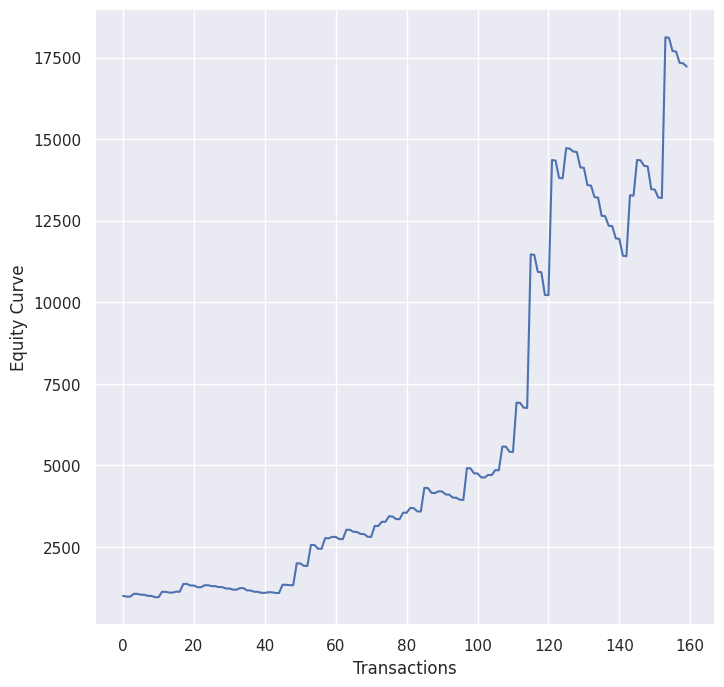

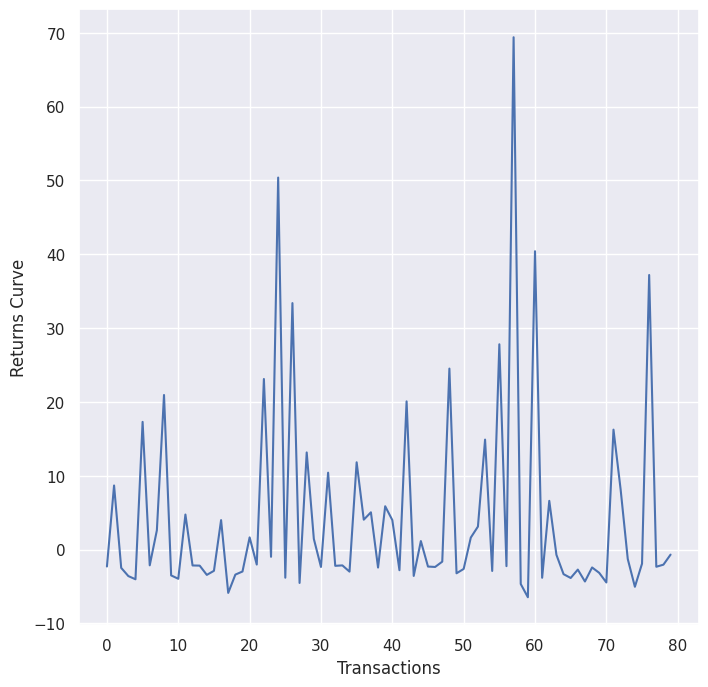

In [89]:
s1 = Strategy_Technical_Analysis(tt)
s1.run(150, 50,TIMEFRAME, 1)
tt.outputTradeHistory()
tt.getstatsCompounded()